# **Preprocessing of the WIDER FACE Dataset**

The [WIDER FACE](https://shuoyang1213.me/WIDERFACE/) dataset is a benchmark for face detection, with images selected from the [WIDER](https://www.cv-foundation.org/openaccess/content_cvpr_2015/html/Xiong_Recognize_Complex_Events_2015_CVPR_paper.html) dataset. It contains a total of 32,203 images and 393,703 annotated faces. WIDER FACE is organized into 61 event classes and includes faces with extreme challenges due to substantial variations, such as ``blur``, ``expression``, ``illumination``, ``occlusion``, ``pose``, and ``invalid`` (low resolution and very small scale annotations). This makes it a robust dataset ideal for evaluating face detection algorithms under complex conditions.  

The dataset is divided into 12,880 training images, 3,226 validation images, and 16,097 test images (the latter do not include annotations and will not be considered for preprocessing). According to its [official paper](https://arxiv.org/pdf/1511.06523), it is also categorized into three difficulty levels: ``Easy``, ``Medium``, and ``Hard``, based on the detection rate of EdgeBox, which evaluates performance relative to the complexity of detection across the 61 event classes. However, for this preprocessing, all event classes will be included to increase the complexity and robustness of the models utilizing this preprocessed dataset.




## **Imports**

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import drive
from tqdm.auto import tqdm
import shutil
import os

In [2]:
# Mount Google Drive in Colab
drive.mount("/content/drive")

Mounted at /content/drive


## **Parameters**

The complete official dataset is available on their [official page](https://shuoyang1213.me/WIDERFACE/). I have added this raw dataset as a shortcut in my personal Google Drive, in a folder named ``Raw_WIDER-FACE``, for further preprocessing.

In [4]:
raw_dataset_path = "/content/drive/MyDrive/Datasets/Raw_WIDER-FACE"
dataset_path = "/content/WIDER-FACE"
zip_data_path = "/content/drive/MyDrive/Datasets/WIDER-FACE.zip"

os.makedirs(dataset_path, exist_ok=True)

## **Unzip the Dataset**

In [ ]:
!unzip -q {os.path.join(raw_dataset_path, "WIDER_train.zip")}
!unzip -q {os.path.join(raw_dataset_path, "WIDER_val.zip")}
!unzip -q {os.path.join(raw_dataset_path, "wider_face_split.zip")}

## **Preprocess the Dataset**

**Contents of the *readme.txt* file:**
```
Attached the mappings between attribute names and label values.

blur:
  clear->0
  normal blur->1
  heavy blur->2

expression:
  typical expression->0
  exaggerate expression->1

illumination:
  normal illumination->0
  extreme illumination->1

occlusion:
  no occlusion->0
  partial occlusion->1
  heavy occlusion->2

pose:
  typical pose->0
  atypical pose->1

invalid:
  false->0(valid image)
  true->1(invalid image)

The format of txt ground truth.
File name
Number of bounding box
x1, y1, w, h, blur, expression, illumination, invalid, occlusion, pose
```

In [ ]:
train_annotations_path = "/content/wider_face_split/wider_face_train_bbx_gt.txt"
val_annotations_path = "/content/wider_face_split/wider_face_val_bbx_gt.txt"

In [ ]:
# Function to extract image paths with their instances
def parse_annotations(annotations_path, split="train"):
  with open(annotations_path, "r") as f:
    labels = {}

    for line in tqdm(f.readlines()):
      line = line.strip()

      # Initialize the image instances with an empty set to avoid duplicates
      if ".jpg" in line:
        image_path = os.path.join(f"/content/WIDER_{split}/images", line)
        labels[image_path] = set()

      # Discard the number of bounding boxes and empty lines
      elif len(line.split()) <= 1:
        continue

      else:
        width_img, height_img = Image.open(image_path).size
        line = [float(e) for e in line.split()]

        # Discard instances with an extremely small scale
        if line[-3] == 0:

          # Normalize the coordinates to the YOLO format
          xmin, ymin, width, height = tuple(line[:4])
          x_center = (xmin + (width / 2)) / width_img
          y_center = (ymin + (height / 2)) / height_img
          width /= width_img
          height /= height_img

          # Normalize the coordinates in the range [0;1]
          label = np.clip([x_center, y_center, width, height], 0, 1)

          labels[image_path].add((0, *label))

  return labels

In [ ]:
train_labels = parse_annotations(train_annotations_path)
val_labels = parse_annotations(val_annotations_path, split="val")

  0%|          | 0/185184 [00:00<?, ?it/s]

  0%|          | 0/46160 [00:00<?, ?it/s]

In [ ]:
n_train_instances = sum([len(v) for v in train_labels.values()])
n_val_instances = sum([len(v) for v in val_labels.values()])

print(f"Number of training images: {len(train_labels)}")
print(f"Number of validation images: {len(val_labels)}")
print(f"Number of training instances: {n_train_instances}")
print(f"Number of validation instances: {n_val_instances}")
print(f"Total number of instances: {n_train_instances + n_val_instances}")

Number of training images: 12880
Number of validation images: 3226
Number of training instances: 157023
Number of validation instances: 39122
Total number of instances: 196145


In [ ]:
# Function to save the images and labels
def save_dataset(labels, name="train"):
  data_path = os.path.join(dataset_path, name)
  images_path = os.path.join(data_path, "images")
  labels_path = os.path.join(data_path, "labels")

  os.makedirs(data_path, exist_ok=True)
  os.makedirs(images_path, exist_ok=True)
  os.makedirs(labels_path, exist_ok=True)

  for image, label in tqdm(labels.items(), total=len(labels)):

    # Discard the empty annotations
    if len(label) > 0:
      id = image.split("/")[-1].split(".")[0]

      # Save the image
      shutil.copy(image, os.path.join(images_path, f"{id}.jpg"))

      # Save the label
      # It is more versatile than np.savetxt as it allows saving a variable number of decimals
      with open(os.path.join(labels_path, f"{id}.txt"), "w") as f:
        for row in label:
          f.write(f"{' '.join([str(e) for e in row])}\n")

    else:
      print(f"Empty annotation: {image}\n")

In [ ]:
save_dataset(train_labels)
save_dataset(val_labels, name="val")

  0%|          | 0/12880 [00:00<?, ?it/s]

  0%|          | 0/3226 [00:00<?, ?it/s]

It can be observed that there were no empty annotations.

In [ ]:
# Create the YAML files with the dataset metadata
with open(os.path.join(dataset_path, "data.yaml"), "w") as f:
  f.write(f"""
  path: WIDER-FACE
  train: train/images
  val: val/images

  names:
    0: face
  """)

In [ ]:
# Compress the dataset into a zip file and save it
!zip -r $zip_data_path WIDER-FACE -q

## **Visualization Example**

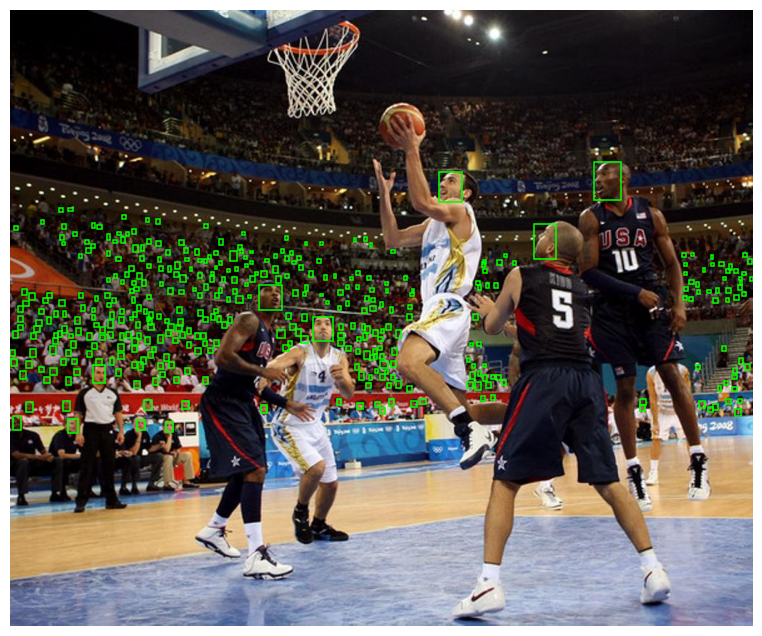

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 8))

image = Image.open("/content/WIDER-FACE/train/images/35_Basketball_basketballgame_ball_35_1041.jpg")
image = np.array(image)
shape = image.shape
ax.imshow(image)

annotation = np.loadtxt("/content/WIDER-FACE/train/labels/35_Basketball_basketballgame_ball_35_1041.txt")
annotation = annotation[None, :] if annotation.ndim == 1 else annotation
classes = annotation[:, 0]
boxes = annotation[:, 1:]

for i in range(len(boxes)):
  box = boxes[i]
  cls = classes[i].astype(np.int32)

  x_center, y_center, width, height = tuple(box)
  xmin = (x_center - width / 2) * shape[1]
  ymin = (y_center - height / 2) * shape[0]
  xmax = (x_center + width / 2) * shape[1]
  ymax = (y_center + height / 2) * shape[0]

  rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1.1, edgecolor=(0.0, 1.0, 0.0), facecolor="none")
  ax.add_patch(rect)

ax.axis("off");